## Surnjani Djoko
## created Nov 28, 2021
## Review Correlation and Feature Selection

# NOTES: I am not happy with categorical imputation using WoE, need to explore other methods!!!

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Define functions

In [2]:
# show visual count of categorical variable

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def view_categorical_count(df, var):
    
    var_count = df[var].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(var_count.index, var_count.values, alpha=0.9)
    plt.title('Frequency Distribution of {var}')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(var, fontsize=12)
    plt.show()
    
# provide quick ratio count of categorical variable
#Getting frequency count of a categorical variable and convert it into percentage
def compute_categorical_value_ratio(df, var):
    return df[var].value_counts()/df[var].count()*100

def inspect_missing_value(df):
    #Calculating percentage of missing values per column
    print(df.isna().mean().round(4) * 100)
    #df.isnull().sum()/df.shape[0]*100
    # remove columns that have more than 90% nan rows
    #df = df.loc[:,df.isnull().sum() < 0.9*df.shape[0]]
    #Get the column with the largest number of missing values
    print(df.isnull().sum().nlargest(5))
    
# check any duplicated row
#df.duplicated().any().sum()

In [3]:
# extract categorical vs. numerical columns
def find_diff_type_var(df):
    cat_var = df.loc[:,df.dtypes == np.object].columns
    num_var = df.loc[:,df.dtypes != np.object].columns
    return(cat_var, num_var)

In [4]:
# numerical correlation
def plot_pearson_correlation(df, cols, low_thres, high_thres):
    # customized
    
    corr_df = df[cols].corr()
    # Get only half portion of corr_df to avoid df, so create mask    
    mask = np.triu(np.ones_like(corr_df), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(corr_df, vmin=-1, vmax=1, cbar=False,
                     cmap='coolwarm', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if low_thres < t < high_thres:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks( size='x-large')
    plt.yticks(rotation=0, size='x-large')
    # Save fig uncomment first
    # plt.savefig("Heatmap DF")
    plt.show()
    return corr_df

In [5]:
# numerical imputation using related segment with groupby
def impute_grpby(df, col, grpby, impt_fct):
    '''
    col is the column to be imputed
    grpby can be a string or list
    impt_fct provide function of imputation - mean, max, min, median, etc.
    ''' 
    #display(df.groupby(grpby,dropna=False)[col].transform(impt_fct))
    df[col] = df[col].fillna(df.groupby(grpby)[col].transform(impt_fct))
    return df[col]

In [6]:
# categorical imputation using WoE
# (1) calculate weight of evidence for each categorical column 
# after reviewing we can decide to use it or not

def IV_WoE(data, col, target, show_woe=True):
    
    newDF, woeDF = pd.DataFrame(), pd.DataFrame()
    do = pd.DataFrame({'x': data[col],'y':data[target]})
    
    #display(do)
    d=do.groupby("x", as_index=False, dropna=False).agg({"y":['count','sum']})
    d.columns=['Category','N','Events']
    #display(d)
    d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
    d['Non-Events'] = d['N'] - d['Events']
    d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
    d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
    d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
    d.insert(loc=0, column='Variable', value=col)
    #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
    temp =pd.DataFrame({"Variable" : [col], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
    newDF=pd.concat([newDF,temp], axis=0)
    woeDF=pd.concat([woeDF,d], axis=0)
    
    #Show WOE Table
    if show_woe == True:
        display(d)
    return newDF, woeDF

## Read and review the dataset

In [65]:
df_all = pd.read_csv('data/fire_incident_station_weather_demo_combined.csv')
print(df_all.shape)
df_all.sample(3)

(17536, 107)


,Unnamed: 0,_id_x,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Numberinc_,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Timeinc_,TFS_Arrival_Time,TFS_Firefighter_Casualties,_id_y,ID,NAME,ADDRESS,ADDRESS_POINT_ID,ADDRESS_ID,CENTRELINE_ID,MAINT_STAGE,ADDRESS_NUMBER,LINEAR_NAME_FULL,POSTAL_CODE,GENERAL_USE,CLASS_FAMILY_DESC,ADDRESS_ID_LINK,PLACE_NAME,X,Y,LATITUDE,LONGITUDE,WARD_NAME,MUNICIPALITY_NAME,OBJECTID,geometry,fs_Longitude,fs_Latitude,Station_Area,LABEL,DISTANCE_INCIDENT_FIRESTATION,INCIDENT_DATE,DOW,IS_WEEKEND,YEAR,MONTH,MINUTES_TO_ARRIVE,TFS_ARR_DAY,TFS_ALM_DAY,TFS_ARR_HOUR,TFS_ALM_HOUR,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,INCIDENT_PERIOD_CAT,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,date,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,Incident_Numberdemo,TFS_Alarm_Timedemo,Latitude,Longitude,location,FSA,fsa_imputed,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male
1720,1720,1948649,64 - Porch or Balcony,01 - Normal (no change),8 - Not applicable (not a business),0,0,0.0,0.0,NaN,2019-06-02 20:29:04,1 - Confined to object of origin,01 - Fire,1 - All persons (at risk of injury) evacuated ...,1 - Fire alarm system operated,1 - Fire alarm system present,2019-06-02 20:29:21,14 - Open Fired Barbeque - Fixed or Portable,F19056261,221,21.0,Fire - Highrise Residential,McCowan Rd / Trudelle St,2019-06-02 20:50:09,005,97 - Other,1 - Extinguished by fire department,15,51,"60 - Other unintentional cause, not classified",323 - Multi-Unit Dwelling - Over 12 Units,2 - Floor/suite of fire origin: Smoke alarm pr...,98 - Not applicable: Alarm operated OR presenc...,2 - Hardwired (standalone),1 - All persons (at risk of injury) self evacu...,2 - Confined to part of room/area of origin,8 - Not applicable - no sprinkler system present,3 - No sprinkler system,3 - Fire with smoke showing only - including v...,2019-06-02 20:17:48,2019-06-02 20:22:01,0,25,26,FIRE STATION 221,2575 EGLINTON AVE E,330710,317332,111065,REGULAR,2575,Eglinton Ave E,NaN,Restaurant,"Land, Structure, Structure Entrance",NaN,NaN,NaN,NaN,NaN,NaN,Scarborough Southwest (20),Scarborough,2048861,"{u'type': u'Point', u'coordinates': (-79.25506...",-79.255063,43.734790,221,0,13676.492629,2019-06-02 00:00:00,6,1,2019,6,4.217,2,2,20,20,28.133,6,Night,0,0,0,0,2019-06-02,2.49,0.00,0.0,16.930,66.200,15.070,F19056261,2019-06-02 20:17:48,43.740590,-79.239298,M1J 2E4,M1J,0,5700.21,0.114064,0.191333,38.1,37.2,0.476158
3703,3703,1950632,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,"03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...",NaN,NaN,NaN,NaN,NaN,F18080237,344,11.0,Check Call,Bloor St W / Howland Ave / Borden St,2018-07-29 19:02:44,NaN,NaN,NaN,1,4,NaN,"896 - Sidewalk, street, roadway, highway, hwy ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-29 18:55:37,2018-07-29 19:00:27,0,58,62,FIRE STATION 344,240 HOWLAND AVE,7974292,121185,30017353,REGULAR,240,Howland Ave,NaN,Fire Station,"Land, Structure, Structure Entrance",NaN,Fire Station 344,NaN,NaN,NaN,NaN,University-Rosedale (11),former Toronto,2997539,"{u'type': u'Point', u'coordinates': (-79.41182...",-79.411824,43.672962,344,0,13685.593666,2018-07-29 00:00:00,6,1,2018,7,4.833,29,29,1

In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Columns: 107 entries, Unnamed: 0 to male
dtypes: float64(28), int64(31), object(48)
memory usage: 14.3+ MB


In [66]:
cat_cols, num_cols = find_diff_type_var(df_all)
print(cat_cols)
print(num_cols)

Index(['Area_of_Origin', 'Building_Status', 'Business_Impact',
       'Ext_agent_app_or_defer_time', 'Extent_Of_Fire', 'Final_Incident_Type',
       'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
       'Fire_Alarm_System_Presence', 'Fire_Under_Control_Time',
       'Ignition_Source', 'Incident_Numberinc_', 'Initial_CAD_Event_Type',
       'Intersection', 'Last_TFS_Unit_Clear_Time', 'Level_Of_Origin',
       'Material_First_Ignited', 'Method_Of_Fire_Control', 'Possible_Cause',
       'Property_Use', 'Smoke_Alarm_at_Fire_Origin',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
       'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
       'Smoke_Spread', 'Sprinkler_System_Operation',
       'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival',
       'TFS_Alarm_Timeinc_', 'TFS_Arrival_Time', 'NAME', 'ADDRESS',
       'MAINT_STAGE', 'LINEAR_NAME_FULL', 'POSTAL_CODE', 'GENERAL_USE',
       'CL

In [9]:
inspect_missing_value(df_all)

Unnamed: 0                                                         0.00
_id_x                                                              0.00
Area_of_Origin                                                    10.91
Building_Status                                                   36.04
Business_Impact                                                   36.05
Civilian_Casualties                                                0.00
Count_of_Persons_Rescued                                           0.00
Estimated_Dollar_Loss                                             10.89
Estimated_Number_Of_Persons_Displaced                             36.05
Exposures                                                         98.10
Ext_agent_app_or_defer_time                                       10.91
Extent_Of_Fire                                                    36.05
Final_Incident_Type                                                0.00
Fire_Alarm_System_Impact_on_Evacuation                          

## Decide which columns to drop for the obvious reasons

In [ ]:
## Drop later after the imputation??

In [67]:
# identifies columns I used and added that are not needed for prediction
my_not_needed_cols = ['Station_Area', 'TFS_Alarm_Timeinc_', 'TFS_Arrival_Time',
                      'YEAR','TFS_ARR_DAY','TFS_ALM_DAY','TFS_ARR_HOUR','TFS_ALM_HOUR']
# additional numerical columns that are not needed
add_num_cols = ['Incident_Station_Area', 'Incident_Ward','ADDRESS_POINT_ID', 'ADDRESS_ID',
       'CENTRELINE_ID', 'ADDRESS_NUMBER', 'OBJECTID', 'fs_Longitude',
       'fs_Latitude', 'Latitude', 'Longitude']
add_cat_cols = ['Intersection', 'Last_TFS_Unit_Clear_Time','TFS_Alarm_Timeinc_', 
        'TFS_Arrival_Time', 'NAME', 'ADDRESS','LINEAR_NAME_FULL', 'PLACE_NAME', 
        'WARD_NAME', 'MUNICIPALITY_NAME', 'geometry','INCIDENT_DATE',
                'Ext_agent_app_or_defer_time','Fire_Under_Control_Time','location']
drop_columns = my_not_needed_cols + add_num_cols + add_cat_cols
df_all.drop(columns=drop_columns, axis=1,inplace=True)
df_all.shape

(17536, 75)

In [68]:
# review after the drop!!
cat_cols, num_cols = find_diff_type_var(df_all)
print(cat_cols)
print(num_cols)

Index(['Area_of_Origin', 'Building_Status', 'Business_Impact',
       'Extent_Of_Fire', 'Final_Incident_Type',
       'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
       'Fire_Alarm_System_Presence', 'Ignition_Source', 'Incident_Numberinc_',
       'Initial_CAD_Event_Type', 'Level_Of_Origin', 'Material_First_Ignited',
       'Method_Of_Fire_Control', 'Possible_Cause', 'Property_Use',
       'Smoke_Alarm_at_Fire_Origin',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
       'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
       'Smoke_Spread', 'Sprinkler_System_Operation',
       'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival', 'MAINT_STAGE',
       'POSTAL_CODE', 'GENERAL_USE', 'CLASS_FAMILY_DESC',
       'INCIDENT_PERIOD_CAT', 'date', 'Incident_Numberdemo',
       'TFS_Alarm_Timedemo', 'FSA'],
      dtype='object')
Index(['Unnamed: 0', '_id_x', 'Civilian_Casualties',
       'Count

## Numerical features

In [69]:
inspect_missing_value(df_all[num_cols])
# only two variables need to be imputed!!

Unnamed: 0                                 0.00
_id_x                                      0.00
Civilian_Casualties                        0.00
Count_of_Persons_Rescued                   0.00
Estimated_Dollar_Loss                     10.89
Estimated_Number_Of_Persons_Displaced     36.05
Exposures                                 98.10
Number_of_responding_apparatus             0.00
Number_of_responding_personnel             0.00
TFS_Firefighter_Casualties                 0.00
_id_y                                      0.00
ID                                         0.00
ADDRESS_ID_LINK                           90.72
X                                        100.00
Y                                        100.00
LATITUDE                                 100.00
LONGITUDE                                100.00
LABEL                                      0.00
DISTANCE_INCIDENT_FIRESTATION              0.01
DOW                                        0.00
IS_WEEKEND                              

### impute 'Estimated_Number_Of_Persons_Displaced'

In [70]:
# review estimated number of persons displaced
df_all.Estimated_Number_Of_Persons_Displaced.describe()
    # only 1 incident has 999 value!! so it is probably ok!
    # can this be imputed based on the count_of_persons_rescued + Civilian_Casualties???

count    11215.000000
mean        17.273295
std        119.066498
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        999.000000
Name: Estimated_Number_Of_Persons_Displaced, dtype: float64

In [71]:
grpby = ['Count_of_Persons_Rescued','Civilian_Casualties']
df_all['Estimated_Number_Of_Persons_Displaced_imputed'] = \
        impute_grpby(df_all, 'Estimated_Number_Of_Persons_Displaced', grpby, 'mean')

In [72]:
# review what is impacted after imputation .....
# review estimated number of persons displaced
df_all.Estimated_Number_Of_Persons_Displaced_imputed.describe()
    # can this be imputed based on the count_of_persons_rescued + Civilian_Casualties???

count    17534.000000
mean        17.015322
std         95.236682
min          0.000000
25%          0.000000
50%          2.000000
75%         16.488225
max        999.000000
Name: Estimated_Number_Of_Persons_Displaced_imputed, dtype: float64

### impute 'Estimated_Dollar_Loss'

In [73]:
# review estimated dollar loss
df_all.Estimated_Dollar_Loss.describe()

count    1.562700e+04
mean     3.499479e+04
std      4.548344e+05
min      0.000000e+00
25%      3.000000e+02
50%      3.000000e+03
75%      1.500000e+04
max      5.000000e+07
Name: Estimated_Dollar_Loss, dtype: float64

## TO DO!

In [74]:
grpby = ['FSA', 'Property_Use','Building_Status','Business_Impact','Extent_Of_Fire']
df_all['Estimated_Dollar_Loss_imputed'] = \
        impute_grpby(df_all, 'Estimated_Dollar_Loss', grpby, 'mean')

In [75]:
# review what is impacted after imputation .....
df_all.Estimated_Dollar_Loss_imputed.describe()

count    1.562700e+04
mean     3.499479e+04
std      4.548344e+05
min      0.000000e+00
25%      3.000000e+02
50%      3.000000e+03
75%      1.500000e+04
max      5.000000e+07
Name: Estimated_Dollar_Loss_imputed, dtype: float64

In [76]:
# Review if the columns are imputed --> not imputed!!
inspect_missing_value(df_all[['Estimated_Dollar_Loss_imputed',
                      'Estimated_Number_Of_Persons_Displaced_imputed']])

Estimated_Dollar_Loss_imputed                    10.89
Estimated_Number_Of_Persons_Displaced_imputed     0.01
dtype: float64
Estimated_Dollar_Loss_imputed                    1909
Estimated_Number_Of_Persons_Displaced_imputed       2
dtype: int64


## Categorical features

In [77]:
inspect_missing_value(df_all[cat_cols])

Area_of_Origin                                                   10.91
Building_Status                                                  36.04
Business_Impact                                                  36.05
Extent_Of_Fire                                                   36.05
Final_Incident_Type                                               0.00
Fire_Alarm_System_Impact_on_Evacuation                           36.05
Fire_Alarm_System_Operation                                      36.05
Fire_Alarm_System_Presence                                       36.05
Ignition_Source                                                  10.91
Incident_Numberinc_                                               0.00
Initial_CAD_Event_Type                                            0.00
Level_Of_Origin                                                  36.05
Material_First_Ignited                                           10.91
Method_Of_Fire_Control                                           10.91
Possib

In [85]:
nan_values = df_all[cat_cols].isna() # return pandas showing null
nan_cols = nan_values.any()
# print nan_cols.index
cols_with_nan = df_all[cat_cols].columns[nan_cols].tolist()
cols_with_nan

['Area_of_Origin',
 'Building_Status',
 'Business_Impact',
 'Extent_Of_Fire',
 'Fire_Alarm_System_Impact_on_Evacuation',
 'Fire_Alarm_System_Operation',
 'Fire_Alarm_System_Presence',
 'Ignition_Source',
 'Level_Of_Origin',
 'Material_First_Ignited',
 'Method_Of_Fire_Control',
 'Possible_Cause',
 'Property_Use',
 'Smoke_Alarm_at_Fire_Origin',
 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
 'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
 'Smoke_Spread',
 'Sprinkler_System_Operation',
 'Sprinkler_System_Presence',
 'Status_of_Fire_On_Arrival',
 'POSTAL_CODE']

In [86]:
cols_with_nan.remove('POSTAL_CODE')

In [88]:
# categorical imputation using WoE, need to review each individual col if it is appropriate
#test_col = ['Business_Impact']
#for cat in test_col:

for cat in cols_with_nan:
    # going through each categorical variable
    iv, woe = IV_WoE(df_all, cat,'LABEL', show_woe=True)
    null_value_ = woe.loc[woe.Category.isnull(),'WoE']
    print(null_value_)
    null_value = float(null_value_)
    temp_df = woe.iloc[(woe['WoE']-(null_value)).abs().argsort()[:2]]
    cat_imputed = temp_df['Category'].iloc[-1]
    print(f'NaN is imputed with {cat_imputed}')
    df_all[cat+'_imputed'] = df_all[cat].fillna(cat_imputed)

,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Area_of_Origin,"11 - Lobby, Entranceway",87,3,0.003021,84,0.005078,-0.519217,1.067784e-03
1,Area_of_Origin,"12 - Hallway, Corridor",150,11,0.011078,139,0.008402,0.276409,7.394487e-04
2,Area_of_Origin,"13 - Stairway, Escalator",88,2,0.002014,86,0.005199,-0.948212,3.019559e-03
3,Area_of_Origin,"18 - Covered Court, Atrium, mall concourse",7,0,0.000504,7,0.000423,0.173930,1.398139e-05
4,Area_of_Origin,19 - Other Means of Egress,14,0,0.000504,14,0.000846,-0.519217,1.779640e-04
5,Area_of_Origin,"21 - Living Area (e.g. living, TV, recreation,...",596,102,0.102719,494,0.029862,1.235425,9.000993e-02
6,Area_of_Origin,22 - Sleeping Area or Bedroom (inc. patients r...,871,186,0.187311,685,0.041407,1.509316,2.202151e-01
7,Area_of_Origin,"23 - Dining or Beverage Area (inc mess, cantee...",81,6,0.006042,75,0.004534,0.287259,4.333752e-04
8,Area_of_Origin,24 - Cooking Area or Kitchen,2878,389,0.391742,2489,0.150456,0.956931,2.308938e-01
9,Area_of_Origin,"25 - Washroom or Bathroom (toilet,restroom/loc...",293,20,0.020141,273,0.016502,0.199248,7.249721e-04


73   -5.436587
Name: WoE, dtype: float64
NaN is imputed with 75 - Trash, rubbish area (outside)


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Building_Status,01 - Normal (no change),9797,896,0.902316,8901,0.538052,0.517009,0.188328
1,Building_Status,02 - Under Renovation,482,24,0.024169,458,0.027685,-0.135828,0.000478
2,Building_Status,03 - Under Construction,152,4,0.004028,148,0.008946,-0.797930,0.003924
3,Building_Status,04 - Under Demolition,16,0,0.000504,16,0.000967,-0.652748,0.000303
4,Building_Status,"05 - Abandoned, vacant (long term)",55,2,0.002014,53,0.003204,-0.464157,0.000552
5,Building_Status,08 - Not Applicable,631,18,0.018127,613,0.037055,-0.715006,0.013534
6,Building_Status,09 - Undetermined,83,7,0.007049,76,0.004594,0.428164,0.001051
7,Building_Status,NaN,6320,42,0.042296,6278,0.379496,-2.194149,0.739867


7   -2.194149
Name: WoE, dtype: float64
NaN is imputed with 03 - Under Construction


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Business_Impact,1 - No business interruption,4491,336,0.338369,4155,0.251164,0.298031,0.025990
1,Business_Impact,2 - May resume operations within a week,642,30,0.030211,612,0.036994,-0.202547,0.001374
2,Business_Impact,3 - May resume operations within a month,126,6,0.006042,120,0.007254,-0.182745,0.000221
3,Business_Impact,4 - May resume operations within a year,34,2,0.002014,32,0.001934,0.040399,0.000003
4,Business_Impact,5 - May not resume operations,63,7,0.007049,56,0.003385,0.733546,0.002688
5,Business_Impact,8 - Not applicable (not a business),5104,515,0.518630,4589,0.277398,0.625737,0.150948
6,Business_Impact,9 - Undetermined,754,55,0.055388,699,0.042254,0.270670,0.003555
7,Business_Impact,NaN,6322,42,0.042296,6280,0.379617,-2.194468,0.740239


7   -2.194468
Name: WoE, dtype: float64
NaN is imputed with 2 - May resume operations within a week


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Extent_Of_Fire,1 - Confined to object of origin,5123,242,0.243706,4881,0.295049,-0.191180,0.009816
1,Extent_Of_Fire,10 - Spread beyond building of origin,56,2,0.002014,54,0.003264,-0.482849,0.000604
2,Extent_Of_Fire,"11 - Spread beyond building of origin, resulte...",120,8,0.008056,112,0.006770,0.173930,0.000224
3,Extent_Of_Fire,2 - Confined to part of room/area of origin,4084,421,0.423968,3663,0.221423,0.649583,0.131570
4,Extent_Of_Fire,3 - Spread to entire room of origin,481,111,0.111782,370,0.022366,1.609015,0.143873
5,Extent_Of_Fire,"4 - Spread beyond room of origin, same floor",469,97,0.097684,372,0.022487,1.468805,0.110450
6,Extent_Of_Fire,5 - Multi unit bldg: spread beyond suite of or...,41,7,0.007049,34,0.002055,1.232537,0.006155
7,Extent_Of_Fire,6 - Multi unit bldg: spread to separate suite(s),34,5,0.005035,29,0.001753,1.055130,0.003463
8,Extent_Of_Fire,"7 - Spread to other floors, confined to building",274,41,0.041289,233,0.014085,1.075521,0.029259
9,Extent_Of_Fire,8 - Entire Structure,99,1,0.001007,98,0.005924,-1.771980,0.008713


12   -2.194468
Name: WoE, dtype: float64
NaN is imputed with 8 - Entire Structure


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Fire_Alarm_System_Impact_on_Evacuation,1 - All persons (at risk of injury) evacuated ...,2015,192,0.193353,1823,0.110198,0.562244,0.046754
1,Fire_Alarm_System_Impact_on_Evacuation,2 - Some persons (at risk) evacuated as a resu...,1240,180,0.181269,1060,0.064075,1.039920,0.121872
2,Fire_Alarm_System_Impact_on_Evacuation,3 - No one (at risk) evacuated as a result of ...,674,40,0.040282,634,0.038324,0.049818,0.000098
3,Fire_Alarm_System_Impact_on_Evacuation,4 - Fire Alarm system operated but failed to a...,38,8,0.008056,30,0.001813,1.491232,0.009310
4,Fire_Alarm_System_Impact_on_Evacuation,7 - Not applicable: Occupant(s) first alerted ...,2561,178,0.179255,2383,0.144049,0.218656,0.007698
5,Fire_Alarm_System_Impact_on_Evacuation,"8 - Not applicable: No fire alarm system, no p...",3075,235,0.236657,2840,0.171674,0.321014,0.020860
6,Fire_Alarm_System_Impact_on_Evacuation,9 - Undetermined,1611,118,0.118832,1493,0.090250,0.275129,0.007864
7,Fire_Alarm_System_Impact_on_Evacuation,NaN,6322,42,0.042296,6280,0.379617,-2.194468,0.740239


7   -2.194468
Name: WoE, dtype: float64
NaN is imputed with 3 - No one (at risk) evacuated as a result of hearing fire alarm system


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Fire_Alarm_System_Operation,1 - Fire alarm system operated,4520,441,0.444109,4079,0.246570,0.588425,0.116237
1,Fire_Alarm_System_Operation,2 - Fire alarm system did not operate,1394,100,0.100705,1294,0.078220,0.252664,0.005681
2,Fire_Alarm_System_Operation,8 - Not applicable (no system),3872,333,0.335347,3539,0.213927,0.449531,0.054582
3,Fire_Alarm_System_Operation,9 - Fire alarm system operation undetermined,1428,77,0.077543,1351,0.081666,-0.051807,0.000214
4,Fire_Alarm_System_Operation,NaN,6322,42,0.042296,6280,0.379617,-2.194468,0.740239


4   -2.194468
Name: WoE, dtype: float64
NaN is imputed with 9 - Fire alarm system operation undetermined


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Fire_Alarm_System_Presence,1 - Fire alarm system present,6216,563,0.566969,5653,0.341716,0.506326,0.114051
1,Fire_Alarm_System_Presence,2 - No Fire alarm system,1794,159,0.160121,1635,0.098833,0.482494,0.029571
2,Fire_Alarm_System_Presence,8 - Not applicable (bldg not classified by OBC...,1942,164,0.165156,1778,0.107477,0.429610,0.024779
3,Fire_Alarm_System_Presence,9 - Undetermined,1262,65,0.065458,1197,0.072357,-0.100199,0.000691
4,Fire_Alarm_System_Presence,NaN,6322,42,0.042296,6280,0.379617,-2.194468,0.740239


4   -2.194468
Name: WoE, dtype: float64
NaN is imputed with 9 - Undetermined


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Ignition_Source,100 - Outdoor fireplace/heater,13,0,0.000504,13,0.000786,-0.445109,0.000126
1,Ignition_Source,"101 - Exposure, source structure detached",5,0,0.000504,5,0.000302,0.510403,0.000103
2,Ignition_Source,"102 - Exposure, source structure semi-detached...",4,1,0.001007,3,0.000181,1.714375,0.001416
3,Ignition_Source,"103 - Exposure, source outside storage contain...",4,0,0.000504,4,0.000242,0.733546,0.000192
4,Ignition_Source,"104 - Exposure, source open fire (inc campfire...",20,0,0.000504,20,0.001209,-0.875892,0.000618
5,Ignition_Source,"105 - Exposure, source forest, trees, wildland",2,0,0.000504,2,0.000121,1.426693,0.000546
6,Ignition_Source,"106 - Exposure, source grass, shrubs, trees",10,0,0.000504,10,0.000604,-0.182745,0.000018
7,Ignition_Source,"107 - Exposure, source vehicle (outside struct...",15,1,0.001007,14,0.000846,0.173930,0.000028
8,Ignition_Source,"108 - Exposure, source other",20,0,0.000504,20,0.001209,-0.875892,0.000618
9,Ignition_Source,"11 - Stove, Range-top burner",1918,299,0.301108,1619,0.097866,1.123867,0.228417


84   -5.436587
Name: WoE, dtype: float64
NaN is imputed with 36 - Fireplace - Masonry


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Level_Of_Origin,001,4327,293,0.295065,4034,0.243849,0.190647,0.009764
1,Level_Of_Origin,002,1370,136,0.136959,1234,0.074593,0.607626,0.037895
2,Level_Of_Origin,003,657,77,0.077543,580,0.035060,0.793765,0.033721
3,Level_Of_Origin,004,317,40,0.040282,277,0.016744,0.877850,0.020663
4,Level_Of_Origin,005,233,27,0.027190,206,0.012452,0.780948,0.011510
5,Level_Of_Origin,006,218,26,0.026183,192,0.011606,0.813589,0.011860
6,Level_Of_Origin,007,171,24,0.024169,147,0.008886,1.000609,0.015293
7,Level_Of_Origin,008,139,22,0.022155,117,0.007072,1.141856,0.017222
8,Level_Of_Origin,009,132,17,0.017120,115,0.006952,0.901269,0.009164
9,Level_Of_Origin,010,119,22,0.022155,97,0.005864,1.329319,0.021657


59   -2.194468
Name: WoE, dtype: float64
NaN is imputed with 996


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Material_First_Ignited,11 - Exterior Roof Covering,147,3,0.003021,144,0.008705,-1.058213,0.006014
1,Material_First_Ignited,12 - Exterior Cladding,140,5,0.005035,135,0.008161,-0.482849,0.001509
2,Material_First_Ignited,13 - Floor,106,7,0.007049,99,0.005984,0.163778,0.000174
3,Material_First_Ignited,14 - Interior Wall/Ceiling,402,15,0.015106,387,0.023394,-0.437387,0.003625
4,Material_First_Ignited,15 - Structural Member,111,1,0.001007,110,0.006649,-1.887493,0.010650
5,Material_First_Ignited,16 - Insulation,332,10,0.010070,322,0.019464,-0.658979,0.006190
6,Material_First_Ignited,19 - Other Building Component,139,3,0.003021,136,0.008221,-1.001055,0.005205
7,Material_First_Ignited,"21 - Upholstered Sofa, Chair, etc.",329,51,0.051360,278,0.016805,1.117192,0.038604
8,Material_First_Ignited,"22 - Non-upholstered Chair, etc.",41,3,0.003021,38,0.002297,0.274014,0.000198
9,Material_First_Ignited,23 - Cabinetry,345,51,0.051360,294,0.017772,1.061234,0.035644


54   -5.436587
Name: WoE, dtype: float64
NaN is imputed with 44 - Creosote (chimney, flue pipe)


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Method_Of_Fire_Control,1 - Extinguished by fire department,11015,600,0.604230,10415,0.629571,-0.041085,0.001041
1,Method_Of_Fire_Control,2 - Extinguished by automatic system,505,18,0.018127,487,0.029438,-0.484905,0.005485
2,Method_Of_Fire_Control,3 - Extinguished by occupant,3036,298,0.300101,2738,0.165508,0.595098,0.080096
3,Method_Of_Fire_Control,4 - Fire self extinguished,704,53,0.053374,651,0.039352,0.304770,0.004273
4,Method_Of_Fire_Control,5 - Action taken unclassified,362,24,0.024169,338,0.020432,0.167996,0.000628
5,Method_Of_Fire_Control,NaN,1914,0,0.000504,1914,0.115698,-5.437110,0.626328


5   -5.43711
Name: WoE, dtype: float64
NaN is imputed with 2 - Extinguished by automatic system


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Possible_Cause,01 - Suspected Arson,206,6,0.006042,200,0.012090,-0.693570,0.004194
1,Possible_Cause,02 - Riot/Civil Commotion,1,0,0.000504,1,0.000060,2.119840,0.000939
2,Possible_Cause,03 - Suspected Vandalism,60,0,0.000504,60,0.003627,-1.974504,0.006167
3,Possible_Cause,04 - Suspected Youth Vandalism (Ages 12 to 17),17,0,0.000504,17,0.001028,-0.713373,0.000374
4,Possible_Cause,11 - Children Playing (Ages 11 and under),79,6,0.006042,73,0.004413,0.314288,0.000512
5,Possible_Cause,12 - Vehicle Accident/Collision,202,9,0.009063,193,0.011667,-0.252478,0.000657
6,Possible_Cause,20 - Design/Construction/Installation/Maintena...,620,15,0.015106,605,0.036571,-0.884191,0.018980
7,Possible_Cause,"28 - Routine maintenance deficiency, eg creoso...",557,7,0.007049,550,0.033247,-1.551020,0.040633
8,Possible_Cause,44 - Unattended,1594,243,0.244713,1351,0.081666,1.097449,0.178936
9,Possible_Cause,45 - Improperly Discarded,1811,74,0.074522,1737,0.104999,-0.342862,0.010450


24   -5.436587
Name: WoE, dtype: float64
NaN is imputed with 03 - Suspected Vandalism


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Property_Use,101 - Theatre - Motion Picture,24,0,0.000504,24,0.001451,-1.058213,1.002382e-03
1,Property_Use,"102 - Theatre - Concert Hall, Live",8,1,0.001007,7,0.000423,0.867078,5.062949e-04
2,Property_Use,"103 - TV, radio, motion picture studio",10,0,0.000504,10,0.000604,-0.182745,1.845001e-05
3,Property_Use,111 - Museum,6,0,0.000504,6,0.000363,0.328081,4.620480e-05
4,Property_Use,112 - Art Gallery,3,0,0.000504,3,0.000181,1.021228,3.290184e-04
5,Property_Use,113 - Library,7,0,0.000504,7,0.000423,0.173930,1.398139e-05
6,Property_Use,114 - Auditorium,4,0,0.000504,4,0.000242,0.733546,1.919914e-04
7,Property_Use,115 - Lecture Hall,1,0,0.000504,1,0.000060,2.119840,9.392507e-04
8,Property_Use,"121 - Bowling Alley, Billiard Centre, pool hall",4,0,0.000504,4,0.000242,0.733546,1.919914e-04
9,Property_Use,122 - Dance Studio,2,0,0.000504,2,0.000121,1.426693,5.458923e-04


283    2.11984
Name: WoE, dtype: float64
NaN is imputed with 702 - Sto: Dairy Goods, Produce


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Smoke_Alarm_at_Fire_Origin,1 - Floor/suite of fire origin: No smoke alarm,2459,151,0.152064,2308,0.139515,0.086131,0.001081
1,Smoke_Alarm_at_Fire_Origin,2 - Floor/suite of fire origin: Smoke alarm pr...,4935,483,0.486405,4452,0.269117,0.591896,0.128612
2,Smoke_Alarm_at_Fire_Origin,3 - Floor/suite of fire origin: Smoke alarm pr...,1724,135,0.135952,1589,0.096053,0.347402,0.013861
3,Smoke_Alarm_at_Fire_Origin,4 - Floor/suite of fire origin: Smoke alarm pr...,750,78,0.078550,672,0.040621,0.659438,0.025011
4,Smoke_Alarm_at_Fire_Origin,9 - Floor/suite of fire origin: Smoke alarm pr...,1346,104,0.104733,1242,0.075077,0.332900,0.009873
5,Smoke_Alarm_at_Fire_Origin,NaN,6322,42,0.042296,6280,0.379617,-2.194468,0.740239


5   -2.194468
Name: WoE, dtype: float64
NaN is imputed with 1 - Floor/suite of fire origin: No smoke alarm


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,1 - No battery,187,25,0.025176,162,0.009793,0.944267,0.014526
1,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,2 - Dead battery,151,20,0.020141,131,0.007919,0.933523,0.011410
2,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,3 - Electrical line or battery not connected,126,18,0.018127,108,0.006528,1.021228,0.011845
3,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,4 - Remote from fire – smoke did not reach alarm,1113,41,0.041289,1072,0.064801,-0.450722,0.010597
4,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,"5 - Separated from fire (e.g. wall, etc)",392,10,0.010070,382,0.023091,-0.829848,0.010805
5,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,6 - Improper installation of unit,45,8,0.008056,37,0.002237,1.281511,0.007458
6,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,7 - Unit failure,173,23,0.023162,150,0.009067,0.937847,0.013219
7,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,8 - Tampered with (vandalism),35,9,0.009063,26,0.001572,1.752116,0.013126
8,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,9 - Other reason,604,51,0.051360,553,0.033428,0.429455,0.007701
9,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,98 - Not applicable: Alarm operated OR presenc...,7770,673,0.677744,7097,0.429003,0.457306,0.113751


11   -2.194468
Name: WoE, dtype: float64
NaN is imputed with 5 - Separated from fire (e.g. wall, etc)


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Smoke_Alarm_at_Fire_Origin_Alarm_Type,1 - Battery operated,2380,290,0.292044,2090,0.126337,0.837949,0.138854
1,Smoke_Alarm_at_Fire_Origin_Alarm_Type,2 - Hardwired (standalone),2276,184,0.185297,2092,0.126458,0.382048,0.022479
2,Smoke_Alarm_at_Fire_Origin_Alarm_Type,3 - Wireless,24,2,0.002014,22,0.001330,0.415092,0.000284
3,Smoke_Alarm_at_Fire_Origin_Alarm_Type,4 - Interconnected,2066,155,0.156093,1911,0.115517,0.301031,0.012214
4,Smoke_Alarm_at_Fire_Origin_Alarm_Type,8 - Not applicable - no smoke alarm or presenc...,2569,149,0.150050,2420,0.146285,0.025411,0.000096
5,Smoke_Alarm_at_Fire_Origin_Alarm_Type,9 - Type undetermined,1899,171,0.172205,1728,0.104455,0.499931,0.033871
6,Smoke_Alarm_at_Fire_Origin_Alarm_Type,NaN,6322,42,0.042296,6280,0.379617,-2.194468,0.740239


6   -2.194468
Name: WoE, dtype: float64
NaN is imputed with 8 - Not applicable - no smoke alarm or presence undetermined


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,1 - All persons (at risk of injury) self evacu...,2997,307,0.309164,2690,0.162607,0.642539,0.094169
1,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,2 - Some persons (at risk) self evacuated as a...,1119,183,0.184290,936,0.056580,1.180858,0.150808
2,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,3 - No one (at risk) evacuated as a result of ...,870,58,0.058409,812,0.049084,0.173930,0.001622
3,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,4 - Alarm operated but failed to alert occupan...,31,14,0.014099,17,0.001028,2.618832,0.034231
4,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,7 - Not applicable: Occupant(s) first alerted ...,2602,212,0.213494,2390,0.144472,0.390525,0.026955
5,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,"8 - Not applicable: No alarm, no persons present",2198,39,0.039275,2159,0.130508,-1.200851,0.109558
6,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,9 - Undetermined,1397,138,0.138973,1259,0.076105,0.602168,0.037857
7,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,NaN,6322,42,0.042296,6280,0.379617,-2.194468,0.740239


7   -2.194468
Name: WoE, dtype: float64
NaN is imputed with 8 - Not applicable: No alarm, no persons present


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Smoke_Spread,10 - Spread beyond building of origin,247,23,0.023162,224,0.013540,0.536836,0.005165
1,Smoke_Spread,2 - Confined to part of room/area of origin,2888,111,0.111782,2777,0.167866,-0.406609,0.022804
2,Smoke_Spread,3 - Spread to entire room of origin,928,72,0.072508,856,0.051744,0.337383,0.007005
3,Smoke_Spread,"4 - Spread beyond room of origin, same floor",2746,300,0.302115,2446,0.147857,0.714561,0.110227
4,Smoke_Spread,5 - Multi unit bldg: spread beyond suite of or...,547,89,0.089627,458,0.027685,1.174755,0.072767
5,Smoke_Spread,6 - Multi unit bldg: spread to separate suite(s),296,40,0.040282,256,0.015475,0.956690,0.023733
6,Smoke_Spread,"7 - Spread to other floors, confined to building",1823,215,0.216516,1608,0.097201,0.800879,0.095556
7,Smoke_Spread,8 - Entire Structure,742,80,0.080564,662,0.040017,0.699749,0.028373
8,Smoke_Spread,9 - Confined to roof/exterior structure,459,7,0.007049,452,0.027323,-1.354784,0.027466
9,Smoke_Spread,99 - Undetermined,538,14,0.014099,524,0.031675,-0.809447,0.014227


10   -2.194468
Name: WoE, dtype: float64
NaN is imputed with 9 - Confined to roof/exterior structure


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Sprinkler_System_Operation,1 - Sprinkler system activated,882,30,0.030211,852,0.051502,-0.533401,0.011356
1,Sprinkler_System_Operation,2 - Did not activate: remote from fire,1637,138,0.138973,1499,0.090612,0.427688,0.020683
2,Sprinkler_System_Operation,3 - Did not activate: fire too small to trigge...,735,42,0.042296,693,0.041891,0.009627,0.000004
3,Sprinkler_System_Operation,4 - Other reason for non activation/operation,114,8,0.008056,106,0.006408,0.228990,0.000378
4,Sprinkler_System_Operation,5 - Did not activate: reason unknown,108,9,0.009063,99,0.005984,0.415092,0.001278
5,Sprinkler_System_Operation,8 - Not applicable - no sprinkler system present,6879,660,0.664653,6219,0.375929,0.569863,0.164533
6,Sprinkler_System_Operation,9 - Activation/operation undetermined,859,64,0.064451,795,0.048057,0.293529,0.004812
7,Sprinkler_System_Operation,NaN,6322,42,0.042296,6280,0.379617,-2.194468,0.740239


7   -2.194468
Name: WoE, dtype: float64
NaN is imputed with 1 - Sprinkler system activated


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Sprinkler_System_Presence,1 - Full sprinkler system present,1737,79,0.079557,1658,0.100224,-0.230932,0.004773
1,Sprinkler_System_Presence,2 - Partial sprinkler system present,1149,102,0.102719,1047,0.063290,0.484276,0.019095
2,Sprinkler_System_Presence,3 - No sprinkler system,6570,644,0.648540,5926,0.358218,0.593582,0.172330
3,Sprinkler_System_Presence,9 - Undetermined,1758,126,0.126888,1632,0.098652,0.251708,0.007107
4,Sprinkler_System_Presence,NaN,6322,42,0.042296,6280,0.379617,-2.194468,0.740239


4   -2.194468
Name: WoE, dtype: float64
NaN is imputed with 1 - Full sprinkler system present


,Variable,Category,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Status_of_Fire_On_Arrival,1 - Fire extinguished prior to arrival,3978,338,0.340383,3640,0.220033,0.436295,0.052508
1,Status_of_Fire_On_Arrival,2 - Fire with no evidence from street,3041,237,0.238671,2804,0.169498,0.342246,0.023674
2,Status_of_Fire_On_Arrival,3 - Fire with smoke showing only - including v...,3999,224,0.225579,3775,0.228193,-0.011522,0.000030
3,Status_of_Fire_On_Arrival,4 - Flames showing from small area (one storey...,2368,125,0.125881,2243,0.135586,-0.074268,0.000721
4,Status_of_Fire_On_Arrival,5 - Flames showing from large area (more than ...,355,21,0.021148,334,0.020190,0.046369,0.000044
5,Status_of_Fire_On_Arrival,"7 - Fully involved (total structure, vehicle, ...",1532,31,0.031219,1501,0.090733,-1.066912,0.063497
6,Status_of_Fire_On_Arrival,8 - Exposure involved,52,1,0.001007,51,0.003083,-1.118838,0.002323
7,Status_of_Fire_On_Arrival,9 - Unclassified,297,16,0.016113,281,0.016986,-0.052778,0.000046
8,Status_of_Fire_On_Arrival,NaN,1914,0,0.000504,1914,0.115698,-5.437110,0.626328


8   -5.43711
Name: WoE, dtype: float64
NaN is imputed with 8 - Exposure involved


In [89]:
df_all.sample(3)

,Unnamed: 0,_id_x,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Ignition_Source,Incident_Numberinc_,Initial_CAD_Event_Type,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,_id_y,ID,MAINT_STAGE,POSTAL_CODE,GENERAL_USE,CLASS_FAMILY_DESC,ADDRESS_ID_LINK,X,Y,LATITUDE,LONGITUDE,LABEL,DISTANCE_INCIDENT_FIRESTATION,DOW,IS_WEEKEND,MONTH,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,INCIDENT_PERIOD_CAT,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,date,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,Incident_Numberdemo,TFS_Alarm_Timedemo,FSA,fsa_imputed,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,Estimated_Number_Of_Persons_Displaced_imputed,Estimated_Dollar_Loss_imputed,Area_of_Origin_imputed,Building_Status_imputed,Business_Impact_imputed,Extent_Of_Fire_imputed,Fire_Alarm_System_Impact_on_Evacuation_imputed,Fire_Alarm_System_Operation_imputed,Fire_Alarm_System_Presence_imputed,Ignition_Source_imputed,Level_Of_Origin_imputed,Material_First_Ignited_imputed,Method_Of_Fire_Control_imputed,Possible_Cause_imputed,Property_Use_imputed,Smoke_Alarm_at_Fire_Origin_imputed,Smoke_Alarm_at_Fire_Origin_Alarm_Failure_imputed,Smoke_Alarm_at_Fire_Origin_Alarm_Type_imputed,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation_imputed,Smoke_Spread_imputed,Sprinkler_System_Operation_imputed,Sprinkler_System_Presence_imputed,Status_of_Fire_On_Arrival_imputed
3018,3018,1949947,"13 - Stairway, Escalator",01 - Normal (no change),8 - Not applicable (not a business),0,0,50.0,0.000000,NaN,1 - Confined to object of origin,01 - Fire,2 - Some persons (at risk) evacuated as a resu...,1 - Fire alarm system operated,1 - Fire alarm system present,77 - Matches or Lighters (unable to distinguish),F18126443,Fire - Residential,B01,"79 - Other Flammable, Combustible Liquid",3 - Extinguished by occupant,6,22,01 - Suspected Arson,321 - Multi-Unit Dwelling - 2 to 6 Units,9 - Floor/suite of fire origin: Smoke alarm pr...,98 - Not applicable: Alarm operated OR presenc...,8 - Not applicable - no smoke alarm or presenc...,2 - Some persons (at risk) self evacuated as a...,"7 - Spread to other floors, confined to building",8 - Not applicable - no sprinkler system present,3 - No sprinkler system,1 - Fire extinguished prior to arrival,0,18,59,REGULAR,NaN,Fire Station,"Land, Structure, Structure Entrance",NaN,NaN,NaN,NaN,NaN,0,13691.809657,0,0,11,3.417,33.233,2,Early Morning,0,0,0,0,2018-11-26,1.83,0.4,0.5,2.13,76.100,17.745,F18126443,2018-11-26 04:15:19,M6E,0,7241.08,0.090047,0.011844,41.3,40.8,0.483044,0.000000,50.0,"13 - Stairway, Escalator",01 - Normal (no change),8 - Not applicable (not a business),1 - Confined to object of origin,2 - Some persons (at risk) evacuated as a resu...,1 - Fire alarm system operated,1 - Fire alarm system present,77 - Matches or Lighters (unable to distinguish),B01,"79 - Other Flammable, Combustible Liquid",3 - Extinguished by occupant,01 - Suspected Arson,321 - Multi-Unit Dwelling - 2 to 6 Units,9 - Floor/suite of fire origin: Smoke alarm pr...,98 - Not applicable: Alarm operated OR presenc...,8 - Not applicable - no smoke alarm or presenc...,2 - Some persons (at risk) self evacuated as a...,"7 - Spread to other floors, confined to building",8 - Not applicable - no sprinkler system present,3 - No sprinkler system,1 - Fire extingui

In [91]:
inspect_missing_value(df_all)

Unnamed: 0                                                                 0.00
_id_x                                                                      0.00
Area_of_Origin                                                            10.91
Building_Status                                                           36.04
Business_Impact                                                           36.05
Civilian_Casualties                                                        0.00
Count_of_Persons_Rescued                                                   0.00
Estimated_Dollar_Loss                                                     10.89
Estimated_Number_Of_Persons_Displaced                                      0.01
Exposures                                                                 98.10
Extent_Of_Fire                                                            36.05
Final_Incident_Type                                                        0.00
Fire_Alarm_System_Impact_on_Evacuation  

###  Numerical correlation

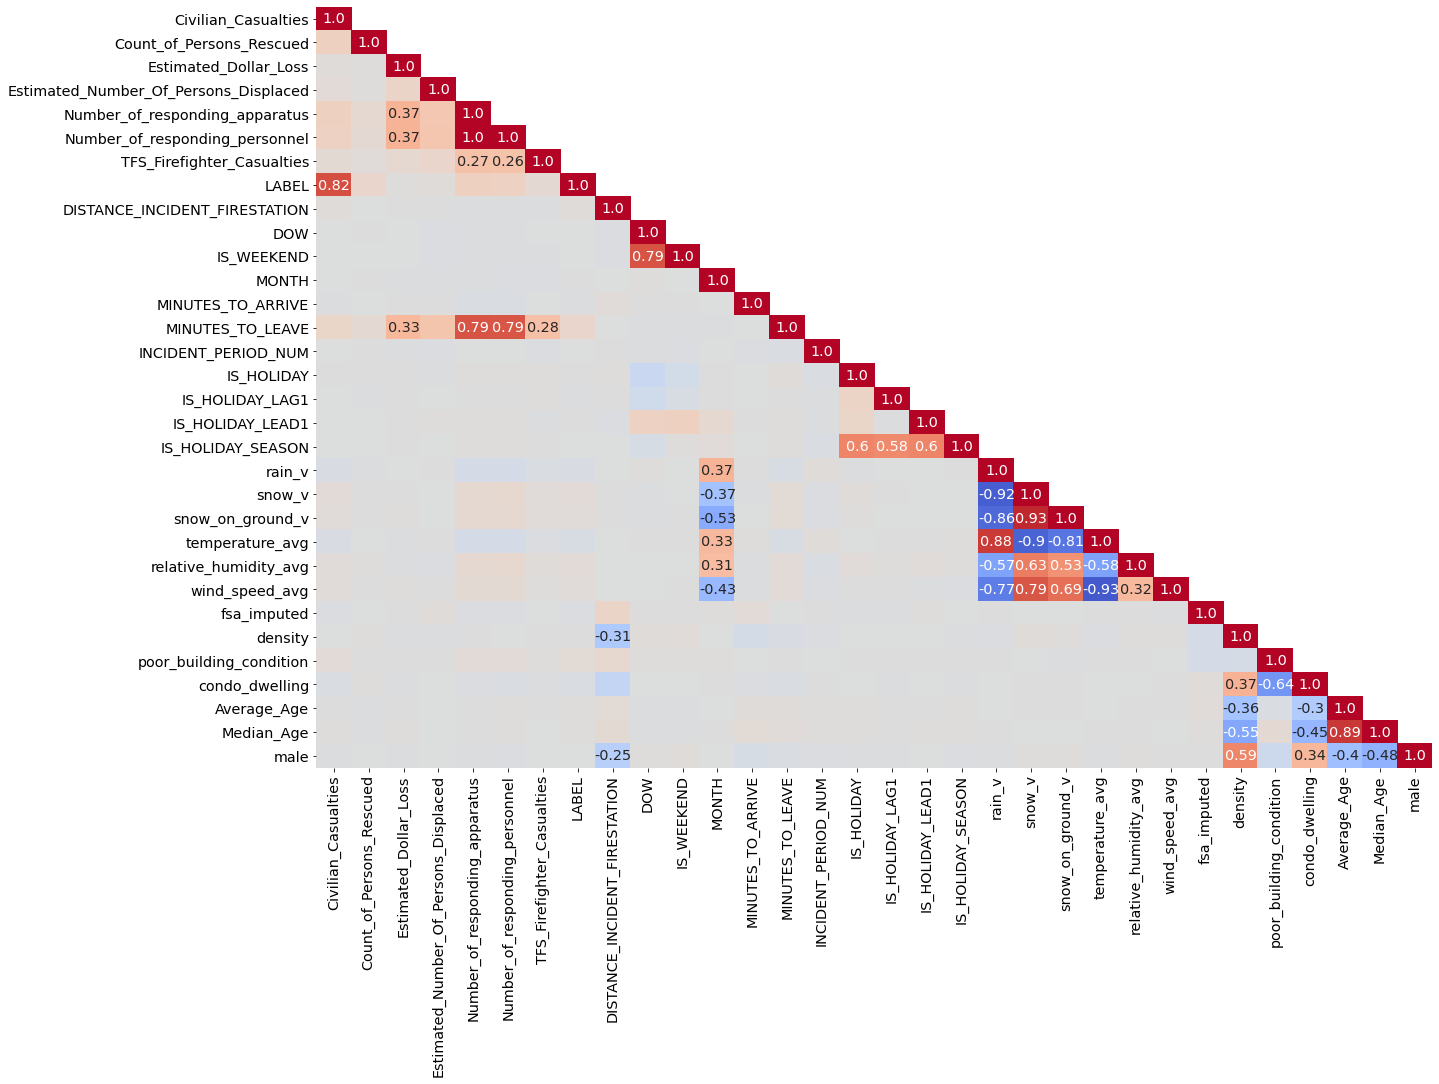

In [21]:
# Only higher correlations are displayed for this data its chosen to be higher than 0.25 or lower than -0.25. 
# U can use your own range.
corr_df = plot_pearson_correlation(df_all, list(num_cols), -0.25, 0.25)

In [22]:
corr_df

,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Number_of_responding_apparatus,Number_of_responding_personnel,TFS_Firefighter_Casualties,LABEL,DISTANCE_INCIDENT_FIRESTATION,DOW,IS_WEEKEND,MONTH,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,fsa_imputed,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male
Civilian_Casualties,1.000000,0.153267,0.016699,0.032552,0.149682,0.146202,0.052862,0.816538,0.020396,-0.000425,-0.001396,-0.003350,-0.012701,0.103104,-0.004947,0.005114,-0.007014,-0.000459,-0.003294,-0.032136,0.036412,0.031012,-0.036060,0.029610,0.029785,-0.017039,-0.005203,0.038624,-0.025324,0.007753,0.013221,-0.009607
Count_of_Persons_Rescued,0.153267,1.000000,0.013733,0.007880,0.063579,0.060434,0.028896,0.094851,-0.000309,0.001529,-0.005554,0.005424,-0.003627,0.055615,0.000710,0.002133,-0.007940,-0.002933,-0.004950,-0.012400,0.004951,0.004826,-0.004301,0.010037,0.001324,-0.007092,0.011526,0.002212,0.009225,-0.011524,-0.013775,-0.002590
Estimated_Dollar_Loss,0.016699,0.013733,1.000000,0.115061,0.366249,0.366768,0.063272,0.009210,0.006833,-0.006189,-0.005957,-0.013959,0.000429,0.330843,-0.013797,0.003216,0.000395,0.001792,0.000567,-0.006286,0.006574,0.008226,-0.009704,-0.008602,0.013979,0.001784,-0.012803,0.000928,-0.011120,0.005271,0.008641,-0.010466
Estimated_Number_Of_Persons_Displaced,0.032552,0.007880,0.115061,1.000000,0.234265,0.234586,0.101038,0.016724,0.003129,-0.020209,-0.020413,-0.010806,0.003530,0.244347,-0.017051,-0.009762,-0.003471,0.010280,-0.002636,0.002178,-0.004462,-0.001825,0.001739,-0.018309,0.004966,0.021095,-0.011933,0.005894,-0.002563,-0.006216,-0.004590,-0.005830
Number_of_responding_apparatus,0.149682,0.063579,0.366249,0.234265,1.000000,0.996649,0.266751,0.149935,-0.009530,-0.010828,-0.010517,-0.014917,-0.026271,0.789064,-0.002622,0.014845,0.003461,0.011074,0.012046,-0.064373,0.069459,0.062788,-0.067733,0.068939,0.049979,-0.021283,0.004050,0.031573,-0.021031,0.004624,0.005887,-0.014097
Number_of_responding_personnel,0.146202,0.060434,0.366768,0.234586,0.996649,1.000000,0.264422,0.147245,-0.009832,-0.012149,-0.013008,-0.015918,-0.026613,0.787706,-0.004325,0.014831,0.003718,0.010563,0.011573,-0.066320,0.071887,0.064545,-0.069728,0.070840,0.051939,-0.022143,-0.001202,0.034566,-0.027584,0.007932,0.011249,-0.018159
TFS_Firefighter_Casualties,0.052862,0.028896,0.063272,0.101038,0.266751,0.264422,1.000000,0.056339,-0.010238,-0.002305,-0.008770,-0.016519,-0.006883,0.278390,-0.016735,0.011746,0.008630,-0.010769,0.003347,-0.023547,0.025611,0.026584,-0.022146,0.017431,0.015108,-0.006975,0.007678,0.013713,-0.015364,0.006896,-0.000389,-0.002315
LABEL,0.816538,0.094851,0.009210,0.016724,0.149935,0.147245,0.056339,1.000000,0.018132,-0.004191,-0.002567,0.003523,-0.014897,0.099920,-0.003041,0.002196,-0.008181,0.003291,-0.002683,-0.032480,0.036632,0.030623,-0.039195,0.035752,0.031140,-0.017181,0.000734,0.041477,-0.025712,0.009734,0.014093,-0.006037
DISTANCE_INCIDENT_FIRESTATION,0.020396,-0.000309,0.006833,0.003129,-0.009530,-0.009832,-0.010238,0.018132,1.000000,-0.018899,-0.018670,-0.005516,0.026112,-0.004606,0.004123,0.007997,0.001607,-0.016066,-0.006729,-0.000816,0.002999,0.003535,-0.000642,-0.002112,-0.001031,0.109857,-0.309454,0.077942,-0.176266,0.044878,0.048499,-0.252598
DOW,-0.000425,0.001529,-0.006189,-0.020209,-0.010828,-0.012149,-0.002305,-0.004191,-0.018899,1.000000,0.790165,0.008361,0.007632,-0.010402,-0.011299,-0.147232,-0.096952,0.144653,-0.051133,0.008093,-0.009223,-0.009349,0.007429,-0.003506,-0.006202,0.000253,0.016810,0.010580,-0.002775,-0.012016,-0.010480,0.010900


In [23]:
corr_df.multiply(100)

,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Number_of_responding_apparatus,Number_of_responding_personnel,TFS_Firefighter_Casualties,LABEL,DISTANCE_INCIDENT_FIRESTATION,DOW,IS_WEEKEND,MONTH,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,fsa_imputed,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male
Civilian_Casualties,100.000000,15.326691,1.669894,3.255164,14.968174,14.620176,5.286196,81.653822,2.039557,-0.042482,-0.139566,-0.335008,-1.270122,10.310424,-0.494725,0.511356,-0.701366,-0.045865,-0.329393,-3.213572,3.641245,3.101224,-3.605986,2.961013,2.978455,-1.703876,-0.520308,3.862409,-2.532416,0.775345,1.322146,-0.960652
Count_of_Persons_Rescued,15.326691,100.000000,1.373340,0.788010,6.357852,6.043367,2.889589,9.485076,-0.030898,0.152926,-0.555446,0.542431,-0.362732,5.561454,0.071035,0.213279,-0.793960,-0.293331,-0.495043,-1.239979,0.495134,0.482636,-0.430077,1.003708,0.132394,-0.709178,1.152553,0.221218,0.922479,-1.152386,-1.377531,-0.259016
Estimated_Dollar_Loss,1.669894,1.373340,100.000000,11.506066,36.624929,36.676789,6.327156,0.921032,0.683349,-0.618893,-0.595655,-1.395938,0.042861,33.084309,-1.379684,0.321638,0.039451,0.179157,0.056676,-0.628621,0.657375,0.822604,-0.970386,-0.860201,1.397923,0.178391,-1.280346,0.092815,-1.111998,0.527096,0.864119,-1.046570
Estimated_Number_Of_Persons_Displaced,3.255164,0.788010,11.506066,100.000000,23.426528,23.458553,10.103752,1.672431,0.312855,-2.020928,-2.041335,-1.080611,0.352981,24.434653,-1.705057,-0.976229,-0.347087,1.027958,-0.263623,0.217807,-0.446169,-0.182513,0.173896,-1.830862,0.496555,2.109506,-1.193256,0.589373,-0.256267,-0.621604,-0.459013,-0.583005
Number_of_responding_apparatus,14.968174,6.357852,36.624929,23.426528,100.000000,99.664877,26.675094,14.993521,-0.953007,-1.082837,-1.051685,-1.491685,-2.627114,78.906428,-0.262230,1.484527,0.346104,1.107417,1.204560,-6.437280,6.945871,6.278806,-6.773287,6.893903,4.997901,-2.128284,0.404999,3.157327,-2.103143,0.462363,0.588667,-1.409704
Number_of_responding_personnel,14.620176,6.043367,36.676789,23.458553,99.664877,100.000000,26.442171,14.724501,-0.983173,-1.214858,-1.300778,-1.591795,-2.661303,78.770572,-0.432460,1.483088,0.371838,1.056290,1.157319,-6.631961,7.188675,6.454539,-6.972825,7.083961,5.193944,-2.214286,-0.120161,3.456611,-2.758412,0.793182,1.124871,-1.815852
TFS_Firefighter_Casualties,5.286196,2.889589,6.327156,10.103752,26.675094,26.442171,100.000000,5.633916,-1.023754,-0.230451,-0.876996,-1.651882,-0.688268,27.839019,-1.673470,1.174576,0.862971,-1.076898,0.334701,-2.354672,2.561131,2.658351,-2.214637,1.743100,1.510825,-0.697469,0.767843,1.371260,-1.536430,0.689586,-0.038917,-0.231542
LABEL,81.653822,9.485076,0.921032,1.672431,14.993521,14.724501,5.633916,100.000000,1.813186,-0.419061,-0.256698,0.352343,-1.489719,9.991964,-0.304081,0.219620,-0.818062,0.329104,-0.268273,-3.247987,3.663184,3.062323,-3.919517,3.575232,3.113992,-1.718091,0.073390,4.147694,-2.571195,0.973384,1.409339,-0.603704
DISTANCE_INCIDENT_FIRESTATION,2.039557,-0.030898,0.683349,0.312855,-0.953007,-0.983173,-1.023754,1.813186,100.000000,-1.889947,-1.866978,-0.551634,2.611191,-0.460611,0.412253,0.799730,0.160675,-1.606644,-0.672943,-0.081646,0.299946,0.353455,-0.064198,-0.211163,-0.103079,10.985667,-30.945376,7.794181,-17.626588,4.487780,4.849938,-25.259778
DOW,-0.042482,0.152926,-0.618893,-2.020928,-1.082837,-1.214858,-0.230451,-0.419061,-1.889947,100.000000,79.016538,0.836081,0.763222,-1.040152,-1.129940,-14.723205,-9.695202,14.465261,-5.113258,0.809303,-0.922331,-0.934910,0.742851,-0.350563,-0.620186,0.025308,1.681050,1.058042,-0.277458,-1.201642,-1.048045,1.089998


## Categorical correlation

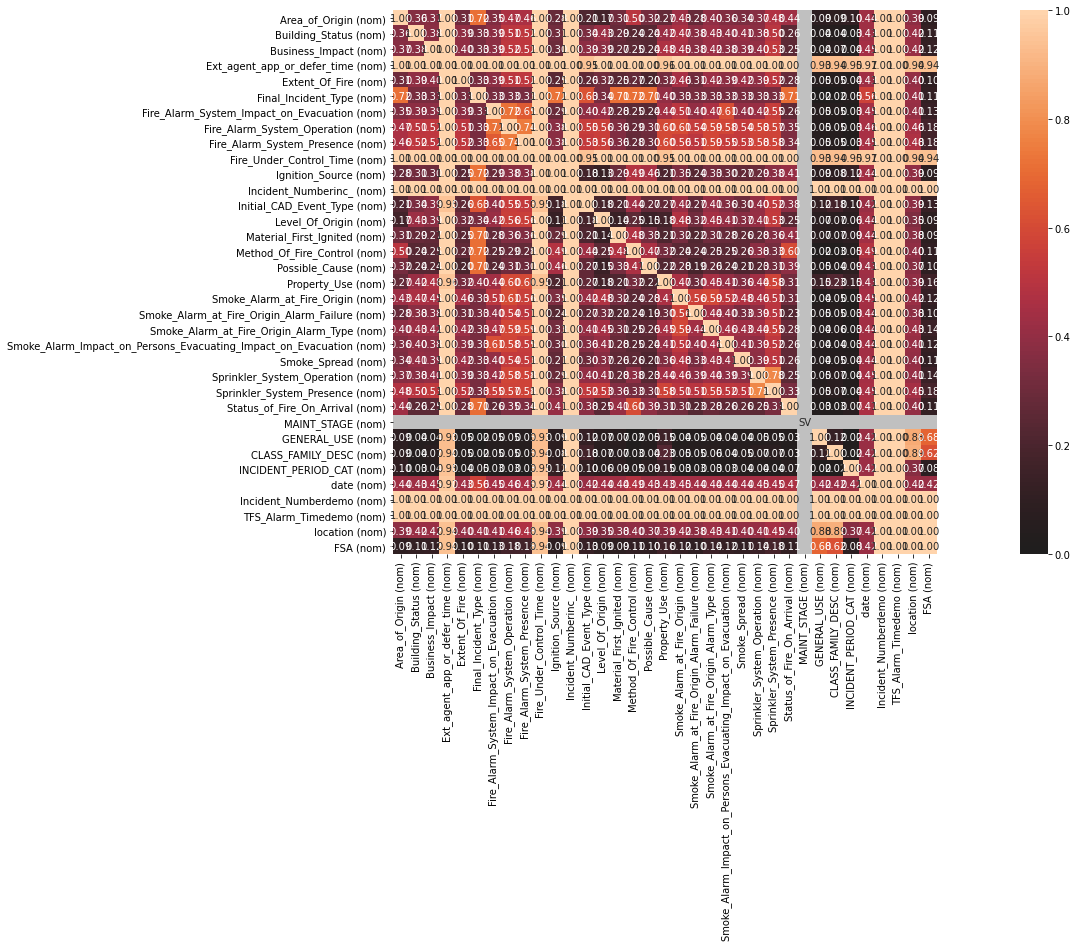

{'corr':                                                     Area_of_Origin (nom)  \
 Area_of_Origin (nom)                                            1.000000   
 Building_Status (nom)                                           0.362135   
 Business_Impact (nom)                                           0.367635   
 Ext_agent_app_or_defer_time (nom)                               0.999608   
 Extent_Of_Fire (nom)                                            0.306025   
 Final_Incident_Type (nom)                                       0.715390   
 Fire_Alarm_System_Impact_on_Evacuation (nom)                    0.352883   
 Fire_Alarm_System_Operation (nom)                               0.467492   
 Fire_Alarm_System_Presence (nom)                                0.461383   
 Fire_Under_Control_Time (nom)                                   0.999698   
 Ignition_Source (nom)                                           0.284987   
 Incident_Numberinc_ (nom)                                       1.0

In [24]:
from dython import nominal

df_all_cat = df_all[cat_cols]
var = cat_cols 

nominal.associations(df_all_cat[df_all_cat.columns.intersection(var)],figsize=(30,10),mark_columns=True,
                    bias_correction=False)

 # #########################